# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 04.12.2021

Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:


airport_key, weather_type_key, loadtime, flight_sched_date_key, flight_sched_time, flight_act_time, flightnum, author, distance, tail_number, airline, depdeplay_min, cancelled, cancellationcode, t, max_gws, w_speed, airtime

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from operator import itemgetter
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.37022411142893

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=100):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    np.random.seed(41)
    # Зададим стартовые вектора 
    sum_of_OOB_preds = np.zeros(X.shape[0], dtype=float)
    count_of_OOB_preds = np.zeros(X.shape[0], dtype=int)
    all_mse = []
    all_preds_by_OOB_index =  np.empty(X.shape[0],dtype=object)
    for num in range(num_runs):
#         bootstrap_index = np.random.choice(range(X.shape[0]),size = X.shape[0])
        # получим набор индексов для обучения
        bootstrap_index = np.random.uniform(0,X.shape[0],size = X.shape[0]).astype(int)
        # зададим единичный вектор
        OOB = np.ones(X.shape[0], dtype=bool)
        # Занулим все индексы, которые мы бырали для обучения
        OOB[bootstrap_index] = False
        # Обучим модель
        regressor.fit(X[bootstrap_index,:],y[bootstrap_index,])
        # Получим предсказания
        preds = regressor.predict(X[OOB,:])
        # Добавим предсказания к предыдущим по соответсвию объект:предсказание
        sum_of_OOB_preds[OOB] += preds
        # Считаем количество предсказания для каждого объекта
        count_of_OOB_preds[OOB] += 1
        # сохраним новые предсказаня для конкретного объектка 
        all_preds_by_OOB_index[OOB] = list((map(lambda x,y: np.append(arr=x,values=y) if not x is None else y,all_preds_by_OOB_index[OOB],preds)))
        # Рассчитаем среднюю ошибку по предсказаниям
        all_mse += [np.mean((y[OOB] - preds)**2)]
    # Рассчитаем общее средннее по всем средним предсказаниям
    loss = np.mean(all_mse)
    # Посчитаем дисперсию для всех объектов, которые были задействованы в предсказании
    std_preds = list(map(lambda x: np.std(x)**2,list(filter(None.__ne__, all_preds_by_OOB_index))))
    # Рассчитаем среднюю дисперсию 
    mean_var = np.mean(std_preds)
    # Посчитаем среднее предсказание по каждому объекту 
    mean_OOB = np.divide(sum_of_OOB_preds,count_of_OOB_preds, where=count_of_OOB_preds!=0)
    # Вычислим разницу 
    substract = np.subtract(y,mean_OOB,where=mean_OOB!=0)
    # Получим квадрат разности
    bias_by_objects = substract**2
    # Рассчитаем среднне отклонение по объектам
    sum_non_zero_counts_bias = np.mean(bias_by_objects, where=count_of_OOB_preds!=0)
    total_bias = sum_non_zero_counts_bias
    return total_bias, mean_var, loss
    
    

In [8]:
compute_biase_variance(LinearRegression(),X,y)

(23.77497163253907, 0.9103871898815269, 24.61107370213319)

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [9]:
compute_biase_variance(LinearRegression(),X,y)

(23.77497163253907, 0.9103871898815269, 24.61107370213319)

In [10]:
compute_biase_variance(DecisionTreeRegressor(),X,y)

(10.706119845955344, 13.04038359921718, 23.821166111046427)

In [11]:
compute_biase_variance(RandomForestRegressor(),X,y)

(11.225914312804608, 2.2886222362507724, 13.52285057438277)

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Да, наши эксперименты согласуются с идеями, обсужденными на занятиях. Например:
- Как и говорилось, Decision Tree не устойчивы к изменению данных и поэтому обладают самым большим показателем разброса
- Как правило смещение маленькое у сложных семейств, а у простых оно большое, в наших экспериментах самое большое смещение у линейной модели
- Random Forest позволяет объединить не смещенные, но чувствительные к данным алгоритмы и получить баланс между параметрами смещенности и разброса

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ Исходя из лекций, бэггинг позволяет уменьшить разброс в N раз, где N это кол-во моделей, но это свойство может не выполняться или выполняться не полностью в случае высокой корреляции моделей. В моем эксперименте данное свойство бэггинга выполняется не для всех моделей, а для некоторых выполняется, но не полностью. Модели могут быть достаточно сильно скоррелированы 

In [12]:
compute_biase_variance(BaggingRegressor(base_estimator=LinearRegression()),X,y)

(23.91458170092826, 1.0594016448932997, 24.85281854307026)

In [13]:
compute_biase_variance(BaggingRegressor(),X,y)

(10.789322170112733, 3.334101633143751, 14.072517773522417)

In [14]:
compute_biase_variance(BaggingRegressor(base_estimator=RandomForestRegressor()),X,y)

(11.874116197141735, 1.3392571661495607, 13.195907270567783)

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [15]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=num_test_objects/X.shape[0],random_state=42)
    
    for num in range(num_runs):
        bootstrap_index = np.random.uniform(0,X_train.shape[0],size = X_train.shape[0]).astype(int)
        regressor.fit(X_train[bootstrap_index,:],y[bootstrap_index,])
        preds = regressor.predict(X_test)
        plt.scatter(range(num_test_objects),preds,c = ['y', 'g', 'r', 'c', 'm', 'b', 'gray', 'brown','pink','purple'])
    plt.scatter(range(num_test_objects),y_test,c='black')
    plt.ylabel("Предсказания моделей")
    plt.xlabel('Номер объекта в тестовой выборке')
    plt.title(title)
    plt.show()
    


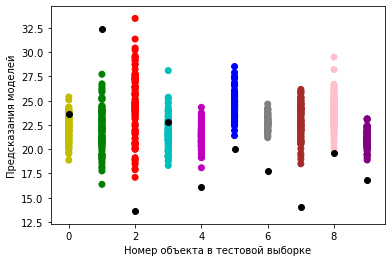

In [16]:
plot_predictions(BaggingRegressor(base_estimator=LinearRegression()),X,y)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

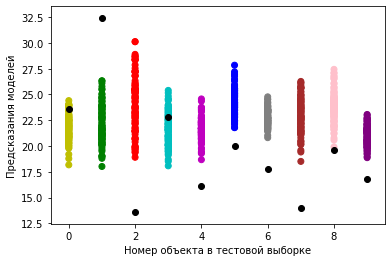

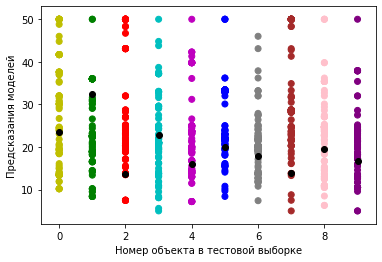

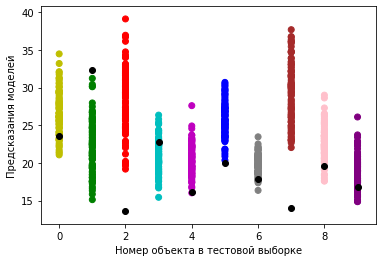

In [17]:

plot_predictions(LinearRegression(),X,y)
plot_predictions(DecisionTreeRegressor(),X,y)
plot_predictions(RandomForestRegressor(),X,y)


__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ 
- Заметим, что на первом графике только 2 черные точки совпали с предсказаниями, это нам говорит о высоком смещении, а длинна столбцов с предсказаниями говорит нам о среднем или минимальном разбросе
- На втором графике уже все черные точки совпали с предсказаниями, следовательно смещение здесь не очень большое, но при этом модель случайного леса имеет высокий разброс, видно, что столбцы очень вытянутые и рваные 
- Случайный лес это некий баланс первых двух алгоритмов, он у него лучше смещение, чем у линейной регрессии и лучше разброс, чем у решающего дерева. Но при этом у него больше смещение относительно решающего дерева и больше разброс относительно линейной регрессии

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

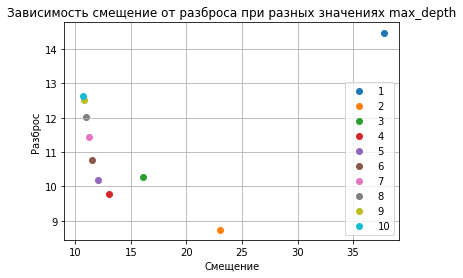

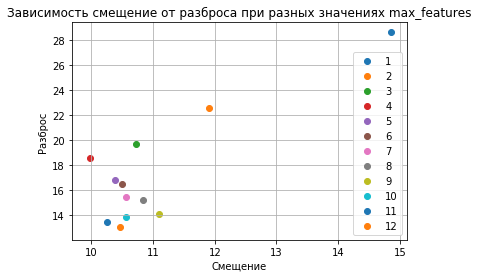

In [18]:
for depth in range(1,11):
    bias,var,_ = compute_biase_variance(DecisionTreeRegressor(max_depth = depth),X,y)
    plt.scatter(bias,var,label = str(depth))
plt.legend()
plt.xlabel('Смещение')
plt.ylabel('Разброс')
plt.title('Зависимость смещение от разброса при разных значениях max_depth')
plt.grid()
plt.show()
for feat in range(1,X.shape[1]):
    bias,var,_ = compute_biase_variance(DecisionTreeRegressor(max_features = feat),X,y)
    plt.scatter(bias,var,label = str(feat))
plt.legend()
plt.xlabel('Смещение')
plt.ylabel('Разброс')
plt.title('Зависимость смещение от разброса при разных значениях max_features')
plt.grid()
plt.show()


__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [19]:
from tqdm import tqdm

100%|██████████| 9/9 [03:25<00:00, 22.82s/it]


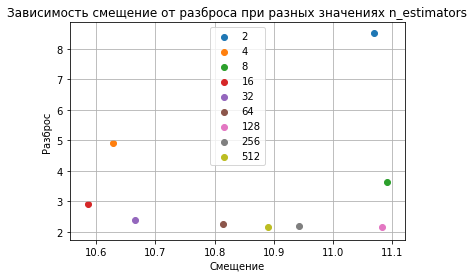

100%|██████████| 9/9 [01:15<00:00,  8.36s/it]


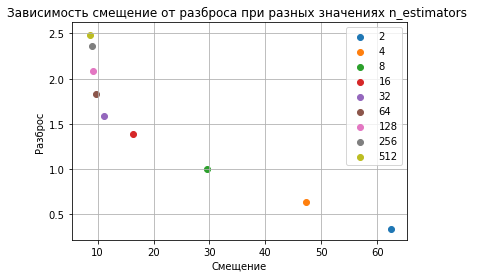

In [20]:
for num in tqdm(2**np.arange(1, 10)):
    bias,var,_ = compute_biase_variance(RandomForestRegressor(n_estimators=num),X,y)
    plt.scatter(bias,var,label = str(num))
plt.legend()
plt.xlabel('Смещение')
plt.ylabel('Разброс')
plt.title('Зависимость смещение от разброса при разных значениях n_estimators')
plt.grid()
plt.show()
for num in tqdm(2**np.arange(1, 10)):
    bias,var,_ = compute_biase_variance(GradientBoostingRegressor(n_estimators=num),X,y)
    plt.scatter(bias,var,label = str(num))
plt.legend()
plt.xlabel('Смещение')
plt.ylabel('Разброс')
plt.title('Зависимость смещение от разброса при разных значениях n_estimators ')
plt.grid()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

- Заметим, что деревья с низкой глубиной имею высокое смещение, так как не могут качественно описать данные. С ростом глубины уменьшается смещение и увеличивается разброс в связи с тем, что дерево начинает переобучаться
- При росте показателя max_features смещение падает, а так же уменьшается и разброс
- При росте количества моделей разброс падает, так как усреднение проводится по большему кол-ву моделей, что нивелирует разброс. При этом, при дальнейшем росте моделей начинает увеличиваться смещение, так как большое количество переобученных моделей так же пагубно влияет на предсказания, как и недостаточное 
- У градиентного бустинга получилось, что с ростом моделей уменьшается смещение, но увеличивается разброс.  Но значения на оси разброса небольшие относительно других моделей.Смещение же уменьшается за счет приближения модели к локальному минимума 

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

<img src = "https://media.giphy.com/media/7kn27lnYSAE9O/giphy.gif">